# Assembly and solution of an advection-diffusion equation

Consider the system
$$ \dfrac{\partial c}{\partial t} + \mathbf{u} \cdot \nabla c = \nabla \cdot D \nabla T + S $$
where $c\in\mathbb{R}$ is a tracer, $D$ is a diffusion tensor (possibly homogeneous and isotropic, in which case $D(x) = dI_{n}$), $\mathbf{u}$ is the flow field, $S$ is some source, and $d$ is the spatial dimension (e.g. $d=2$).

This notebook demonstrates how a transient problem may be solved in PorePy. We consider the advective-diffusive tracer transport problem for a prescribed flow field.


In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp

from PIL import Image
import glob

In [26]:
def add_transport_data(g, d, parameter_keyword):
    # Method to assign data.
    # Boundary conditions: zero Dirichlet everywhere
    # TODO: Update boundary conditions
    #       Could be 0 dirichlet for large enough domain, or 0 Neumann at outflow boundaries and 0 dirichlet at inflow
    b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
    bc_val = np.zeros(g.num_faces)
    labels = np.array(["dir"] * b_faces.size)
    bc = pp.BoundaryCondition(g, b_faces, labels)

    # velocity field (on faces)
    # TODO: update velocity field; based on constant velocity or Met data
    flux_vals = - np.ones(g.num_faces)

    # diffusion coefficient
    # TODO: update diffusion coefficient; could be different at all grid cells
    # Estimate diffusion coefficient of smoke particulates in air
    diffusion = 1.0 * np.ones(g.num_cells)
    diff = pp.SecondOrderTensor(diffusion)

    # source term
    # TODO: source term: strength of emission, and possible location of emission
    f = np.zeros(g.num_cells)
    f[int(g.num_cells / 2) + 10] = 1.0 # <- applies S = 1 at center of domain; maybe automate this instead of hardcoded +10

    # Inherit the aperture assigned for the flow problem
    specified_parameters = {
        "bc": bc,
        "bc_values": bc_val,
        "time_step": 1 / 2,
        "mass_weight": 1.0,
        "t_max": 10.0,
        "darcy_flux": flux_vals,
        "second_order_tensor": diff,
        "source": f
        }
    pp.initialize_default_data(g, d, parameter_keyword, specified_parameters)

We start by making a grid bucket, pecifying the keywords for the parameters of the flow and transport problem, respectively. Then we assigne the problem data and visualize the domain.

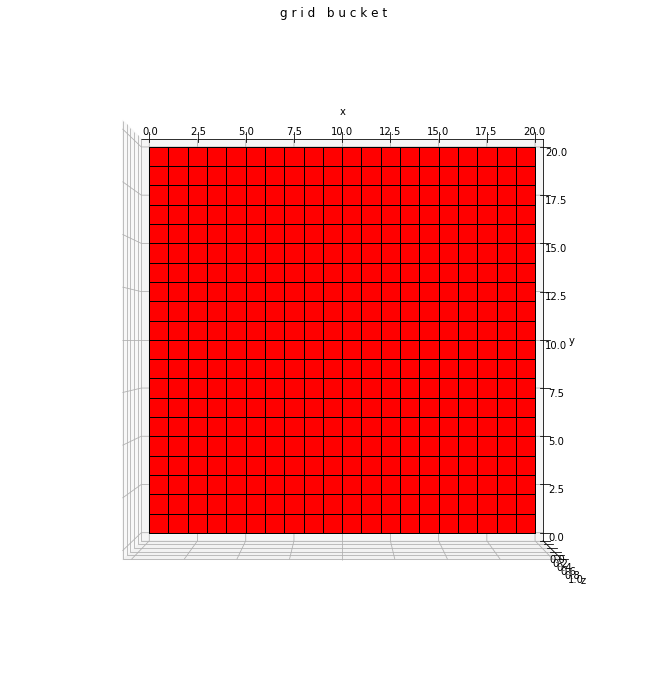

In [27]:
# Create grid
from porepy.fracs.meshing import grid_list_to_grid_bucket
n = 20
g = pp.CartGrid([n,n])
gb = grid_list_to_grid_bucket([[g]])
g = gb.get_grids()[0]
d = gb.node_props(g)
kw_t = 'transport'
# Transport related parameters 
add_transport_data(g, d, kw_t)
pp.plot_grid(gb, figsize=(15, 12))

Prepare for assembly of the transport problem. The procedure is similar to the one above for the flow problem. Here, the purely advective case is shown, but a diffusive term may easily be added.

In [28]:
grid_variable = "tracer"

# Identifier of the discretization operator on each grid
advection_term = "advection"
source_term = "source"
mass_term = "mass"
diffusion_term = 'diffusion'

# Discretization objects
node_discretization = pp.Upwind(kw_t)
source_discretization = pp.ScalarSource(kw_t)
mass_discretization = pp.MassMatrix(kw_t)
diffusion_discretization = pp.Tpfa(kw_t)

# Assign primary variables on this grid. It has one degree of freedom per cell.
d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
# Assign discretization operator for the variable.
d[pp.DISCRETIZATION] = {
    grid_variable: {
        advection_term: node_discretization,
        source_term: source_discretization,
        mass_term: mass_discretization,
        diffusion_term: diffusion_discretization,
    }
}

Assemble the linear system, using the information stored in the GridBucket. By not adding the matrices, we can arrange them at will to obtain the efficient solver defined below, which LU factorizes the system only once for all time steps.

In [29]:
assembler = pp.Assembler(gb)

# Discretize all terms
assembler.discretize()

# Assemble the linear system, using the information stored in the GridBucket
A, b = assembler.assemble_matrix_rhs()

tracer_sol = sps.linalg.spsolve(A, b)

assembler.distribute_variable(tracer_sol)

In [30]:
# Use a filter to let the assembler consider grid and mortar variable only
filt = pp.assembler_filters.ListFilter(variable_list=[grid_variable])

assembler = pp.Assembler(gb)

assembler.discretize(filt=filt)

A, b = assembler.assemble_matrix_rhs(
    filt=filt, add_matrices=False
)

mass_term += "_" + grid_variable
advection_term += "_" + grid_variable
source_term += "_" + grid_variable
diffusion_term += "_" + grid_variable

time_step = d[pp.PARAMETERS][kw_t]["time_step"]
t_max = d[pp.PARAMETERS][kw_t]["t_max"]

lhs = A[mass_term] + time_step * (
    A[advection_term] + A[diffusion_term]
)
rhs_source_adv = b[source_term] + time_step * (
    b[advection_term] + b[diffusion_term]
)

IEsolver = sps.linalg.factorized(lhs)

/Users/emilydejong/opt/anaconda3/envs/porepy/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Prepare for solving the transient problem and exporting the solution.

In [33]:
save_every = 1
n_steps = int(np.round(t_max / time_step))

# Initial condition
tracer = np.zeros(rhs_source_adv.size)
assembler.distribute_variable(
    tracer, variable_names=[grid_variable]
)

# Exporter
folder = "tracer_transport"
exporter = pp.Exporter(gb, file_name="tracer", folder_name=folder)
export_fields = ["tracer"]

!mkdir "tracer_vis"

Solve the tracer transport problem in a time loop, exporting for some of the steps.

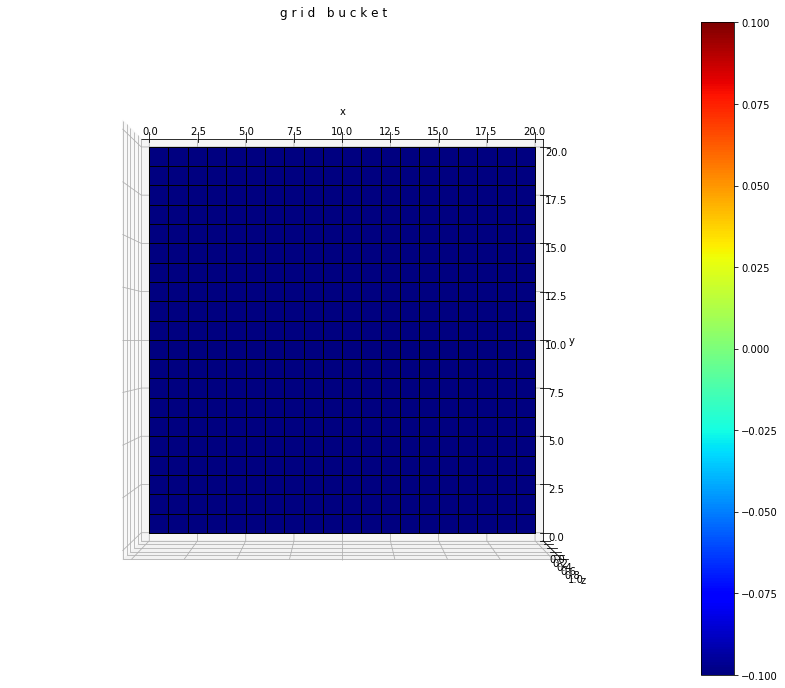

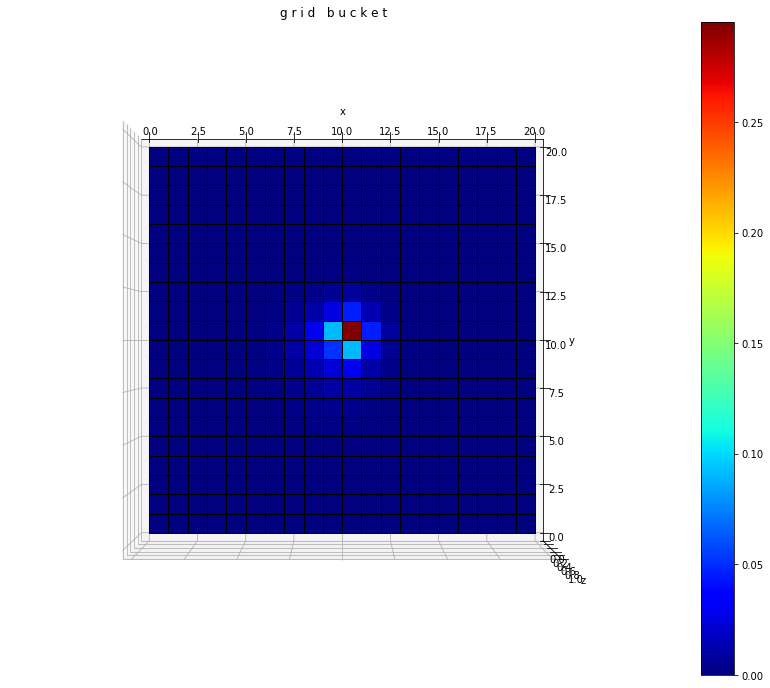

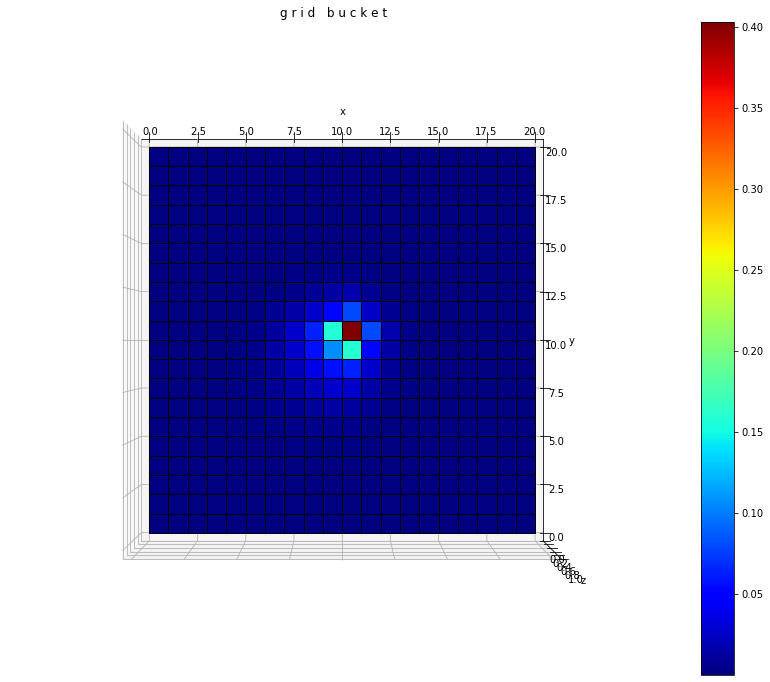

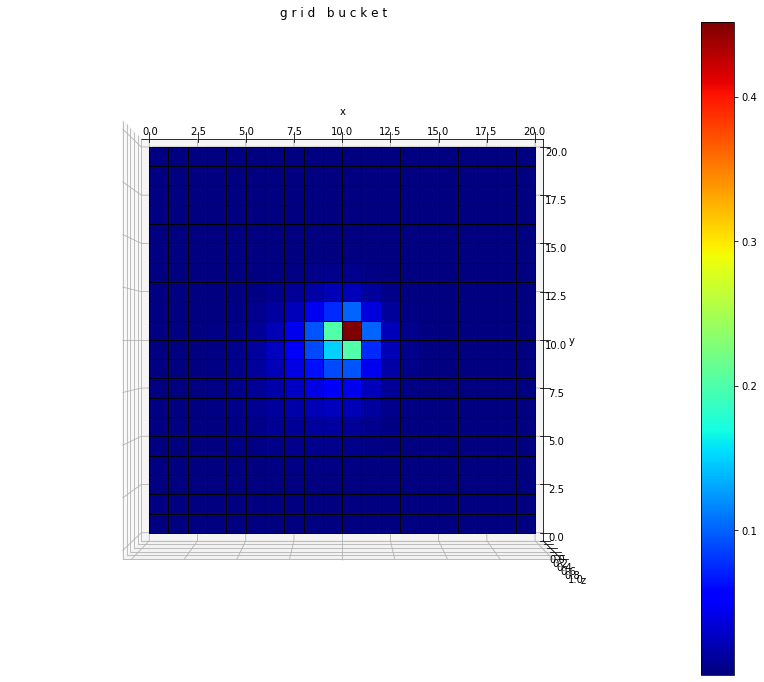

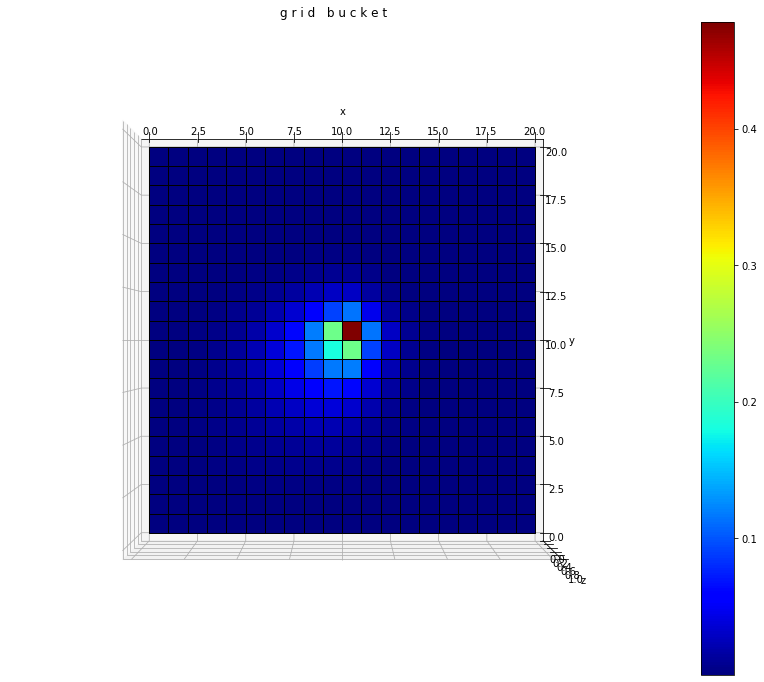

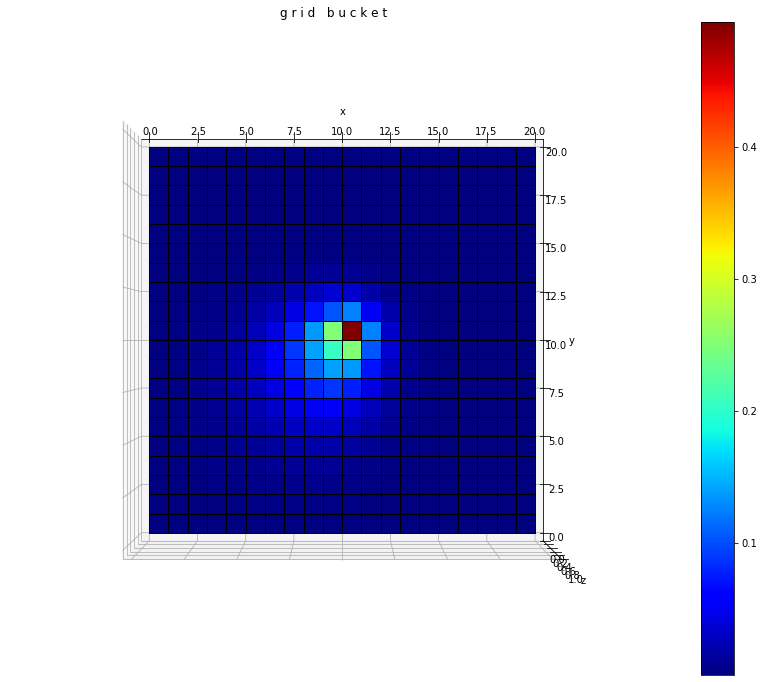

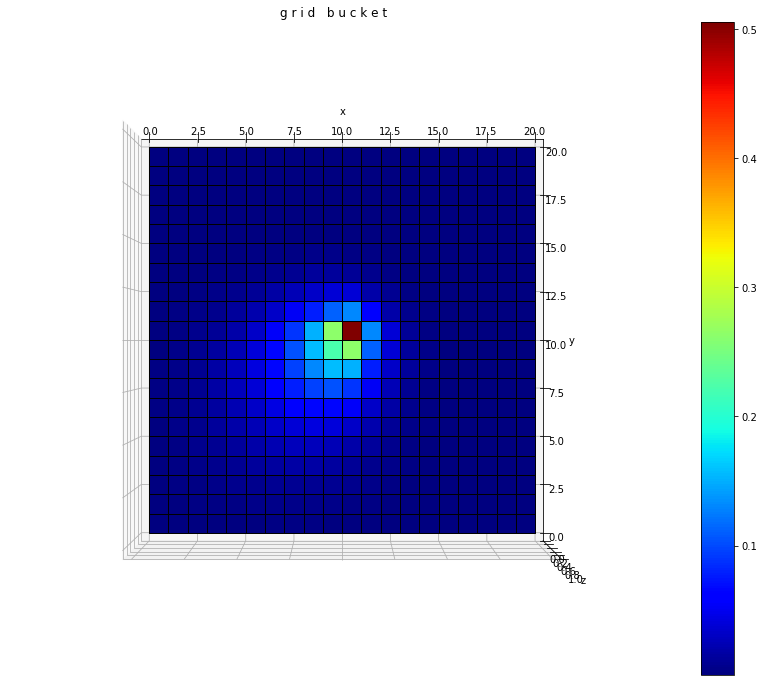

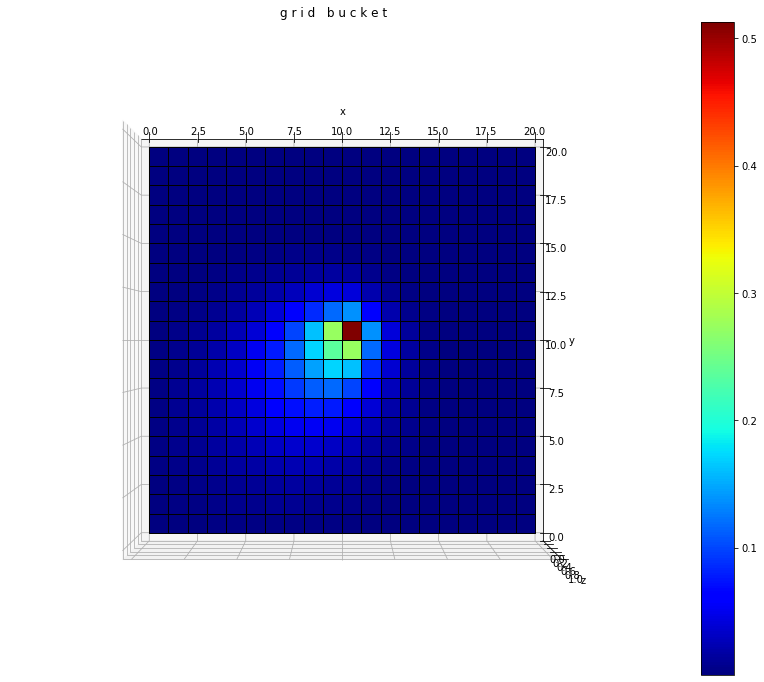

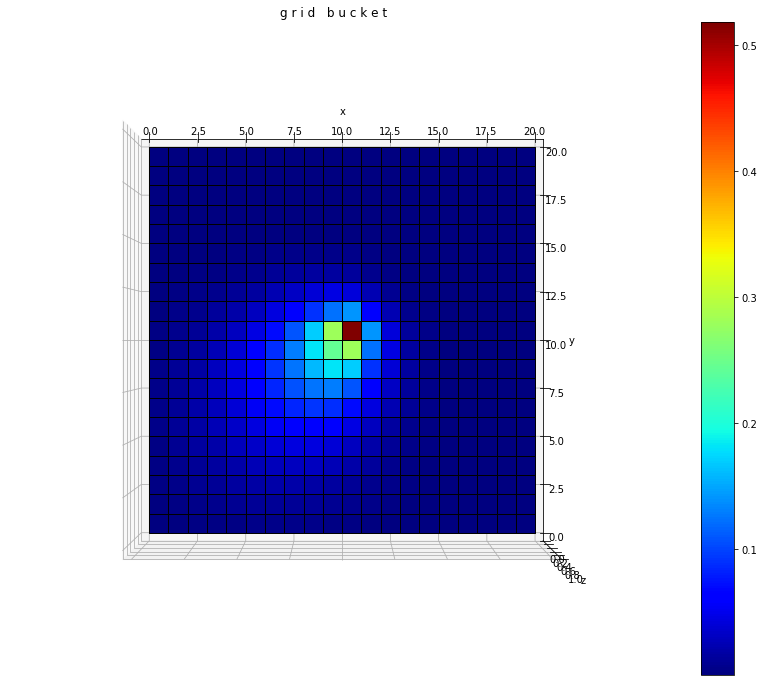

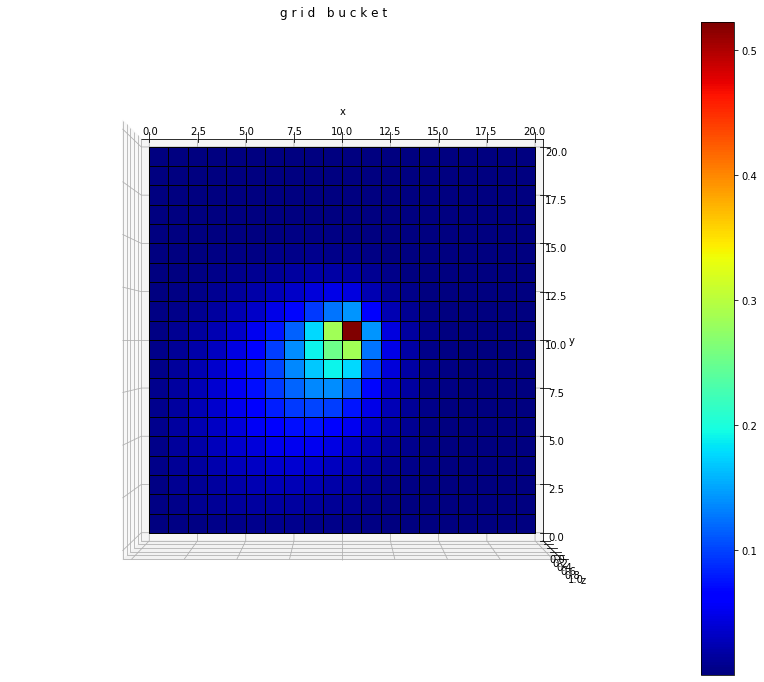

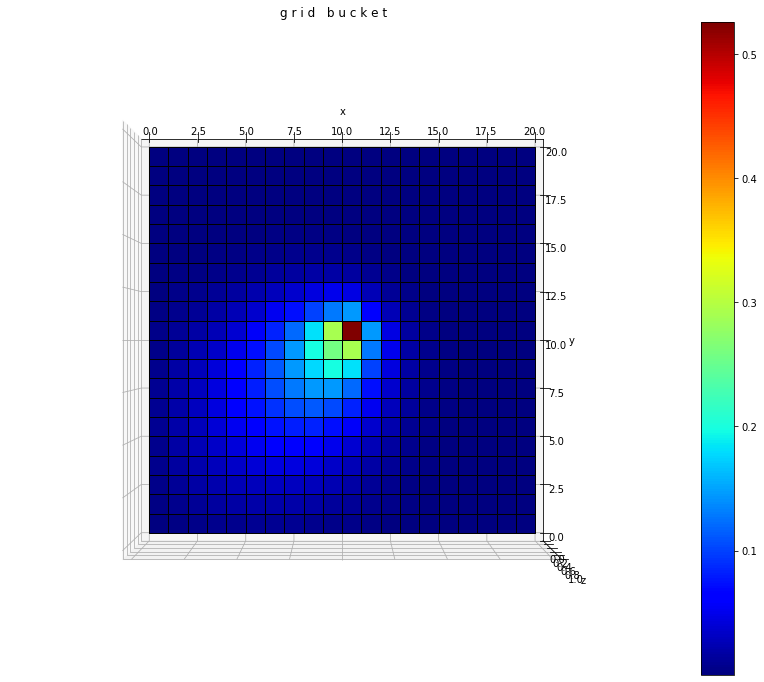

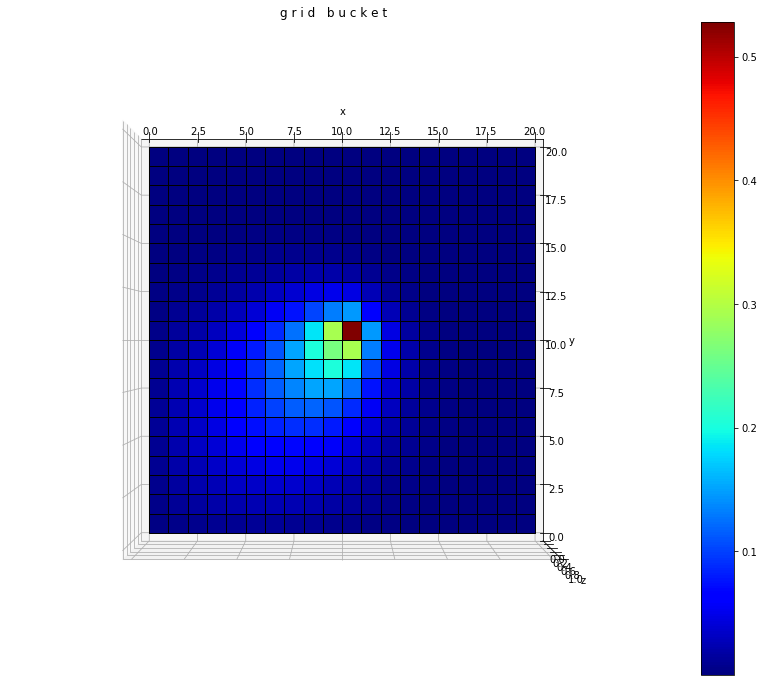

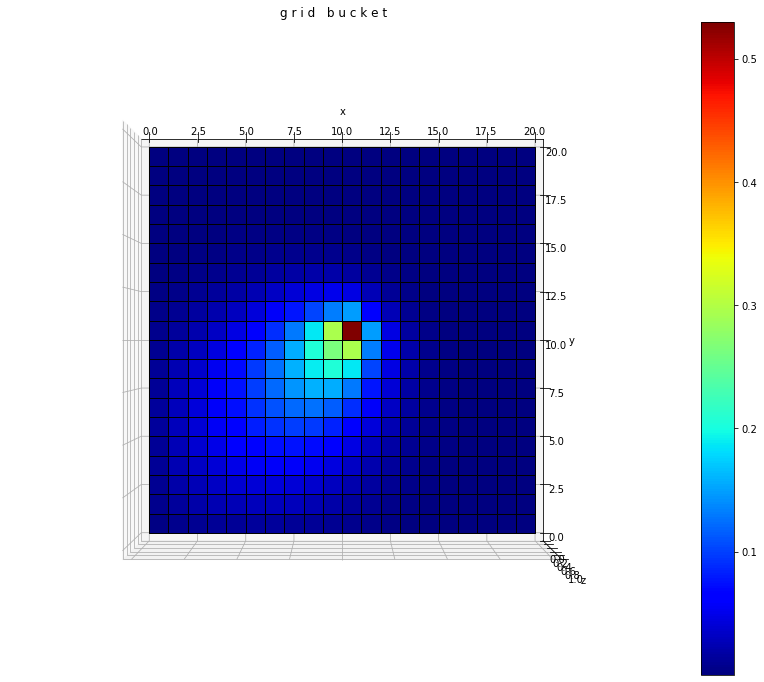

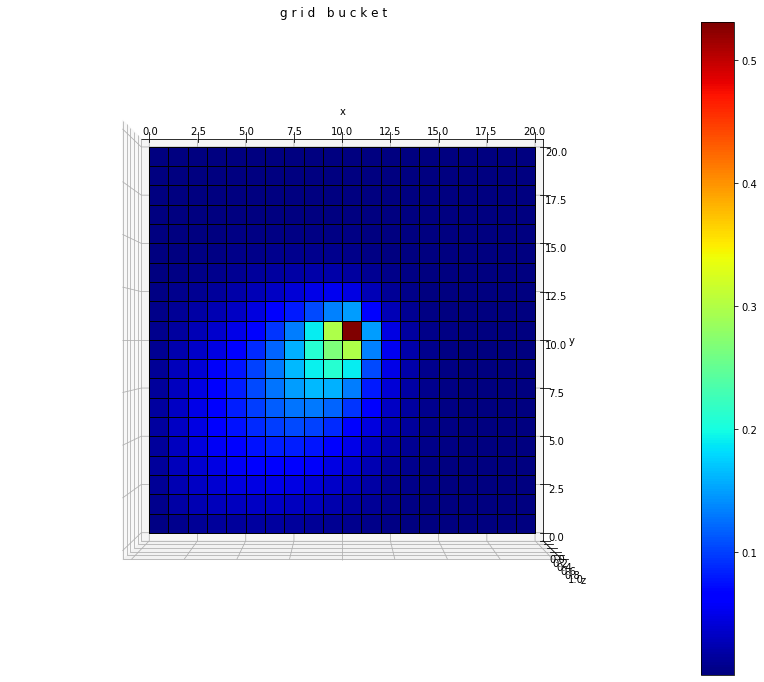

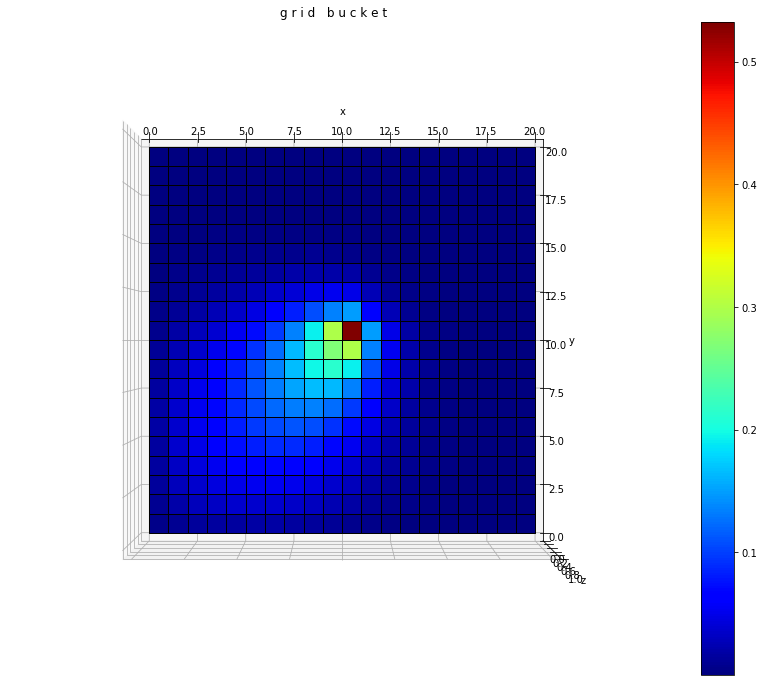

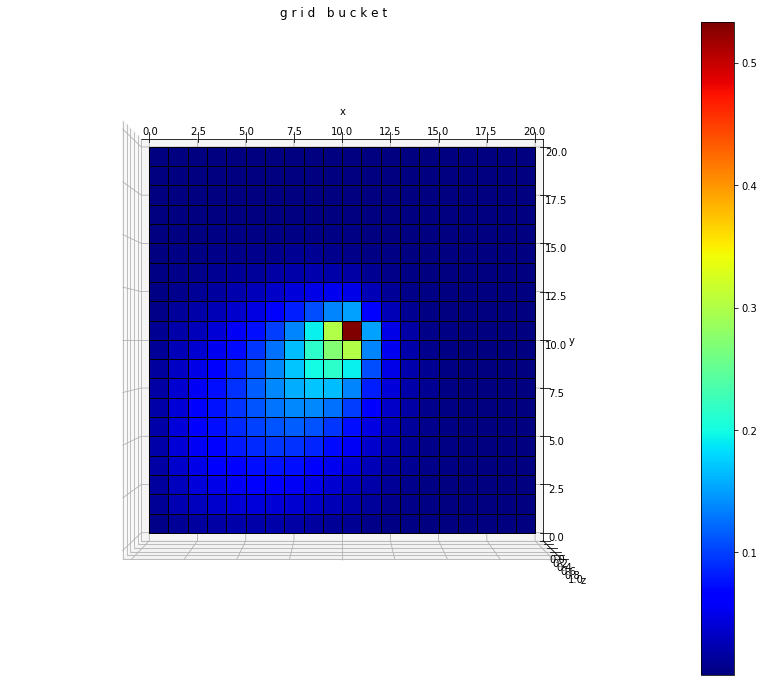

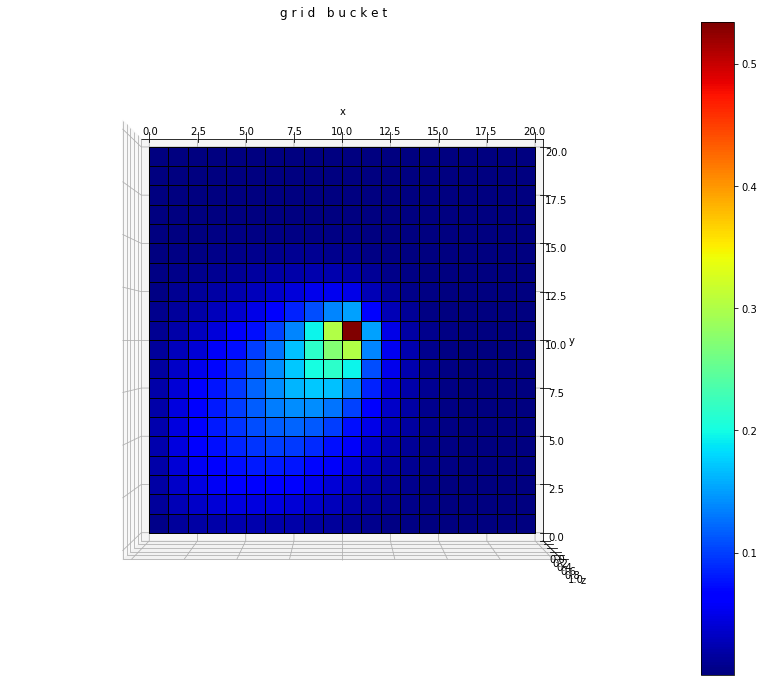

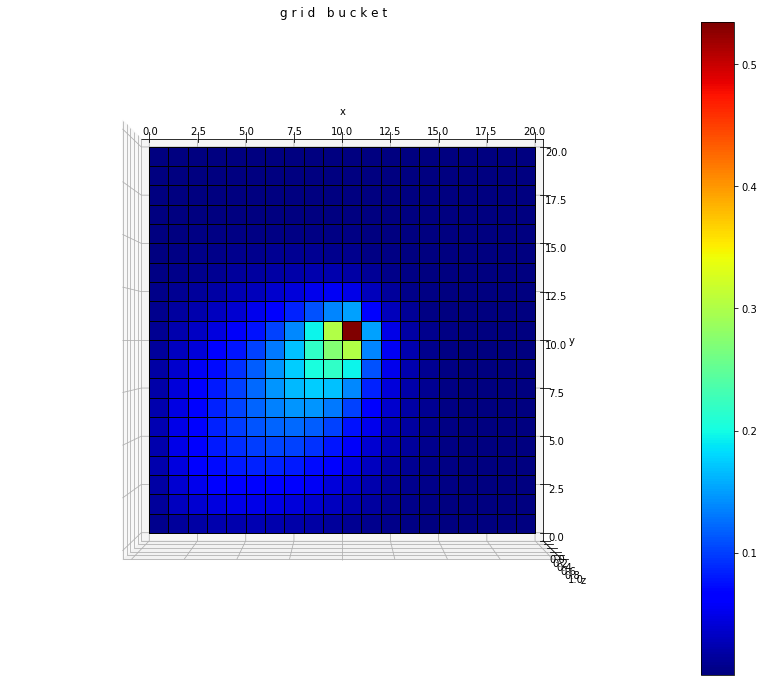

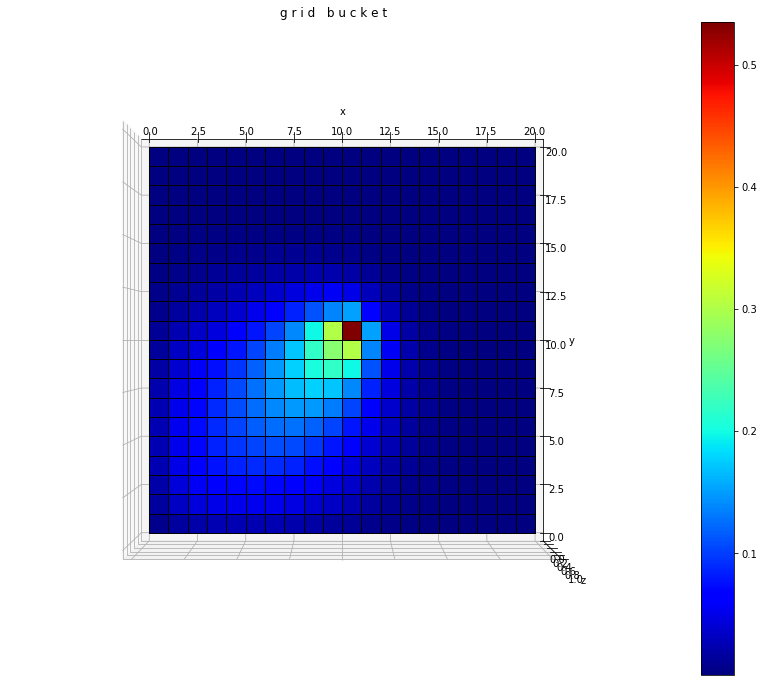

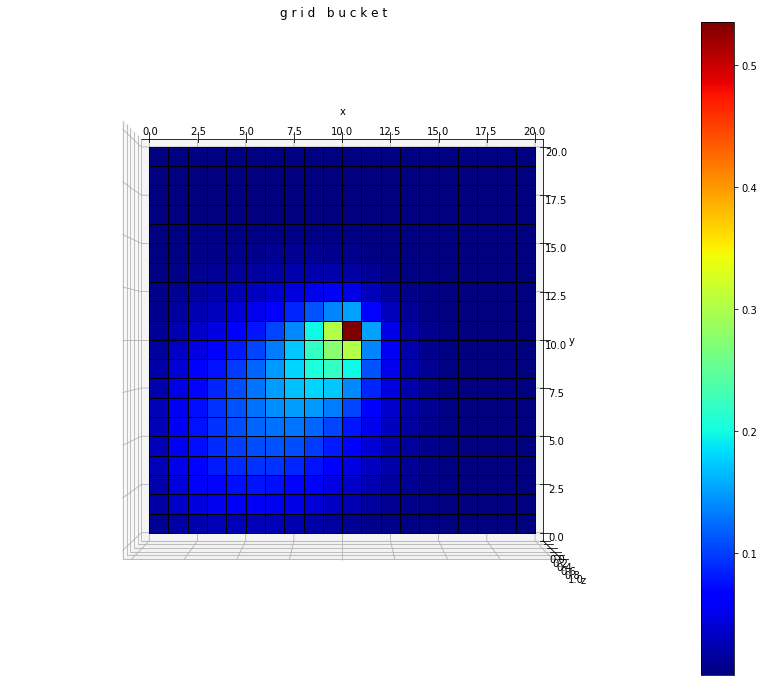

In [34]:
for i in range(n_steps):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler.distribute_variable(
        tracer,
        variable_names=[grid_variable],
    )
        exporter.write_vtu(export_fields, time_step=int(i // save_every))
        pp.save_img("tracer_vis/tracer_" + str(int(i // save_every)) + ".png", gb, grid_variable, figsize=(15,12))
    tracer = IEsolver(A[mass_term] * tracer + rhs_source_adv)

    
    

#exporter.write_vtu(export_fields, time_step=(n_steps // save_every))
#time_steps = np.arange(
#    0, t_max + time_step, save_every * time_step
#)
#exporter.write_pvd(time_steps)

In [36]:
frames = []
imgs = glob.glob("tracer_vis/*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save('test_gif.gif', format='GIF',append_images=frames[1:],save_all=True,duration=300,loop=0)

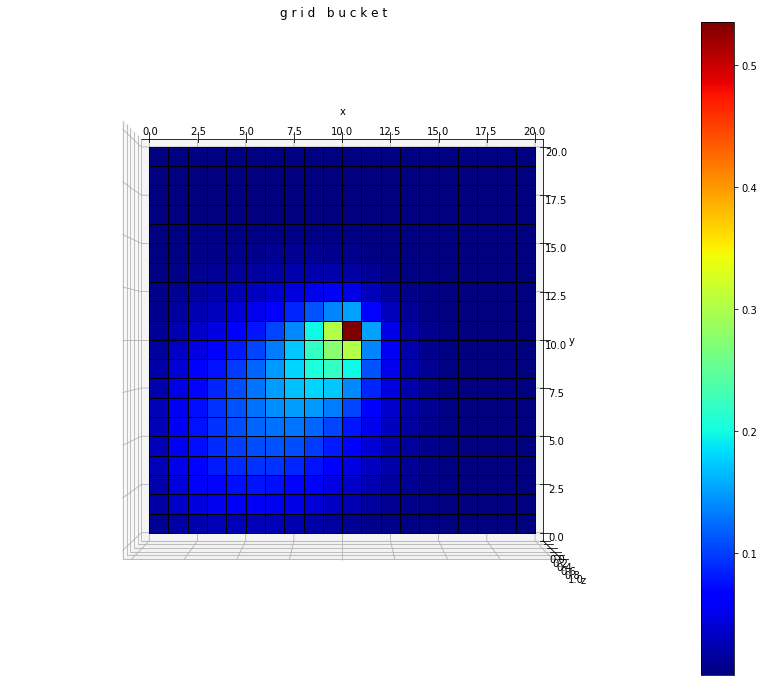

In [22]:
pp.save_img("test.png",gb, grid_variable, figsize=(15, 12))

We plot the final tracer distribution.

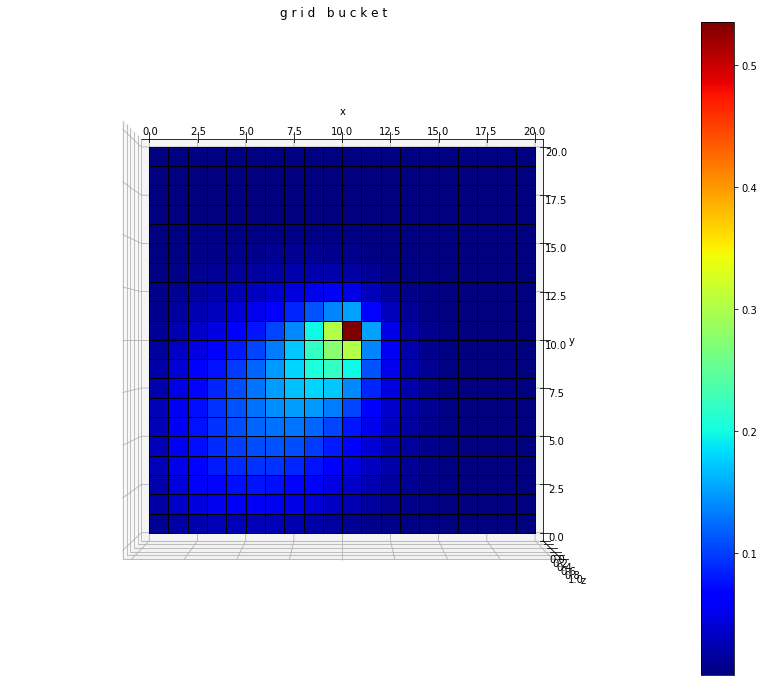

In [10]:
fig = pp.plot_grid(gb, grid_variable, figsize=(15, 12))